In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector


In [308]:
df = pd.read_csv('ds_practical.txt', sep='|')

# Cleaning Data (Preprocessing)


In [309]:
#Basic Info
print(df.head())
print(df.info())

##Checking nulls -- lots of nulls in state and age. May drop these rows or impute
print(df.isnull().sum())


   anon_person_id  target state  presence_of_child_ind streaming_media_subs  \
0               1       0    CA                      0                    N   
1               2       0    CA                      0                    N   
2               3       1    CA                      0                    Y   
3               4       0    CA                      1                    N   
4               5       0    CA                      0                    N   

   streaming_entertainment_subs marital_status  gender      income  \
0                             0              M  Female  $175k-199k   
1                             0              U    Male  $225k-249k   
2                             1              S  Female  $150k-174k   
3                             0              U  Female  $125k-149k   
4                             0              U  Female  $175k-199k   

   number_of_news_subs   age  
0                    0  43.0  
1                    0  90.0  
2          

In [ ]:
#Dropping rows with no values. Will try to impute later to see if it makes a difference in model performance.
#df = df.dropna() 

In [310]:
#Fixing the gender column of 'feMalee' to 'Female'
df = df.replace('feMalee', 'Female')

#Adding in mean age for missing ages
df['age'].fillna(df['age'].mean(), inplace = True)

#Getting most common occurances for missing states
df['state'].fillna(df['state'].mode()[0],inplace = True)

#Checking
print(df.isnull().sum())
print(df.shape)

anon_person_id                  0
target                          0
state                           0
presence_of_child_ind           0
streaming_media_subs            0
streaming_entertainment_subs    0
marital_status                  0
gender                          0
income                          0
number_of_news_subs             0
age                             0
dtype: int64
(1000000, 11)


# Exploratory Data Analysis


In [304]:
#Summary Statistics - lots of discrete variables, hardly any continous variables. Mostly categorical.
print(df.describe())

               target  presence_of_child_ind  streaming_entertainment_subs  \
count  1000000.000000         1000000.000000                1000000.000000   
mean         0.149743               0.144680                      0.173690   
std          0.356820               0.351778                      0.378843   
min          0.000000               0.000000                      0.000000   
25%          0.000000               0.000000                      0.000000   
50%          0.000000               0.000000                      0.000000   
75%          0.000000               0.000000                      0.000000   
max          1.000000               1.000000                      1.000000   

       number_of_news_subs             age  
count       1000000.000000  1000000.000000  
mean              0.205013       46.851937  
std               0.771099       14.870038  
min               0.000000       19.000000  
25%               0.000000       40.000000  
50%               0.000000 

In [311]:
#Taking a look at the target column 
print(df['target'].value_counts())

#Percentages - Quite abit of class imbalance but not that bad. Perhaps will try SMOTE depending on model performance
print(df['target'].value_counts(normalize=True))

0    850257
1    149743
Name: target, dtype: int64
0    0.850257
1    0.149743
Name: target, dtype: float64


income
$100k-124k     38721
$125k-149k     82265
$150k-174k    145620
$175k-199k    211465
$200k-224k    230618
$225k-249k    173852
$250k+         80069
$25k-49k         839
$50k-74k        4507
$75k-99k       15007
<$25k             79
U              16958
Name: anon_person_id, dtype: int64


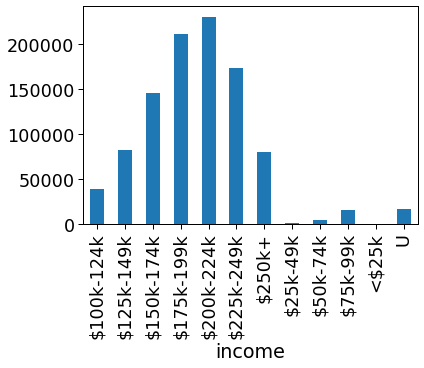

In [312]:
#Taking a look at the income column
print(df.groupby('income')['anon_person_id'].count())

barplot = df.groupby('income')['anon_person_id'].count() 

#plotting
barplot.plot(kind='bar')
plt.show()

[]

<Figure size 1728x1440 with 0 Axes>

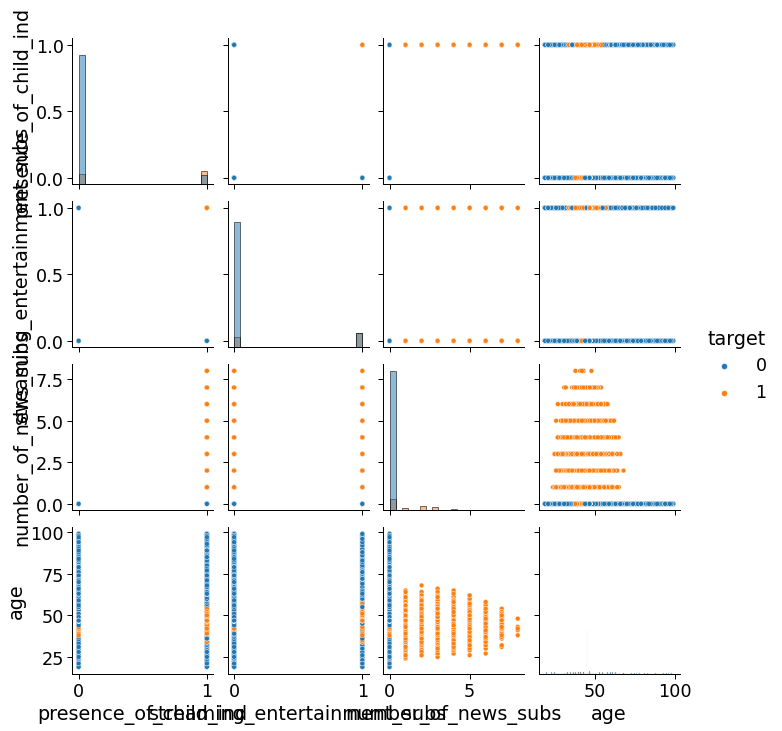

In [272]:
#Checking out all variables against each other - Takes long, not too informative due to many categorical and binary columns
#fig = plt.figure(figsize=(24,20))
#sns.pairplot(df, hue='target', diag_kind="hist")
#plt.plot()


In [313]:
#numerical columns
num_cols = selector(dtype_exclude=['object','category'])
num_cols = num_cols(df)

#discrete features
disc = ['target', 'presence_of_child_ind', 'number_of_news_subs', 'streaming_entertainment_subs']

#Continous features
cont = []
for i in num_cols:
    if i not in disc:
        cont.append(i)
        
#Categorical features 
cat_cols = selector(dtype_include=['object','category'])
cat_cols = cat_cols(df)
 


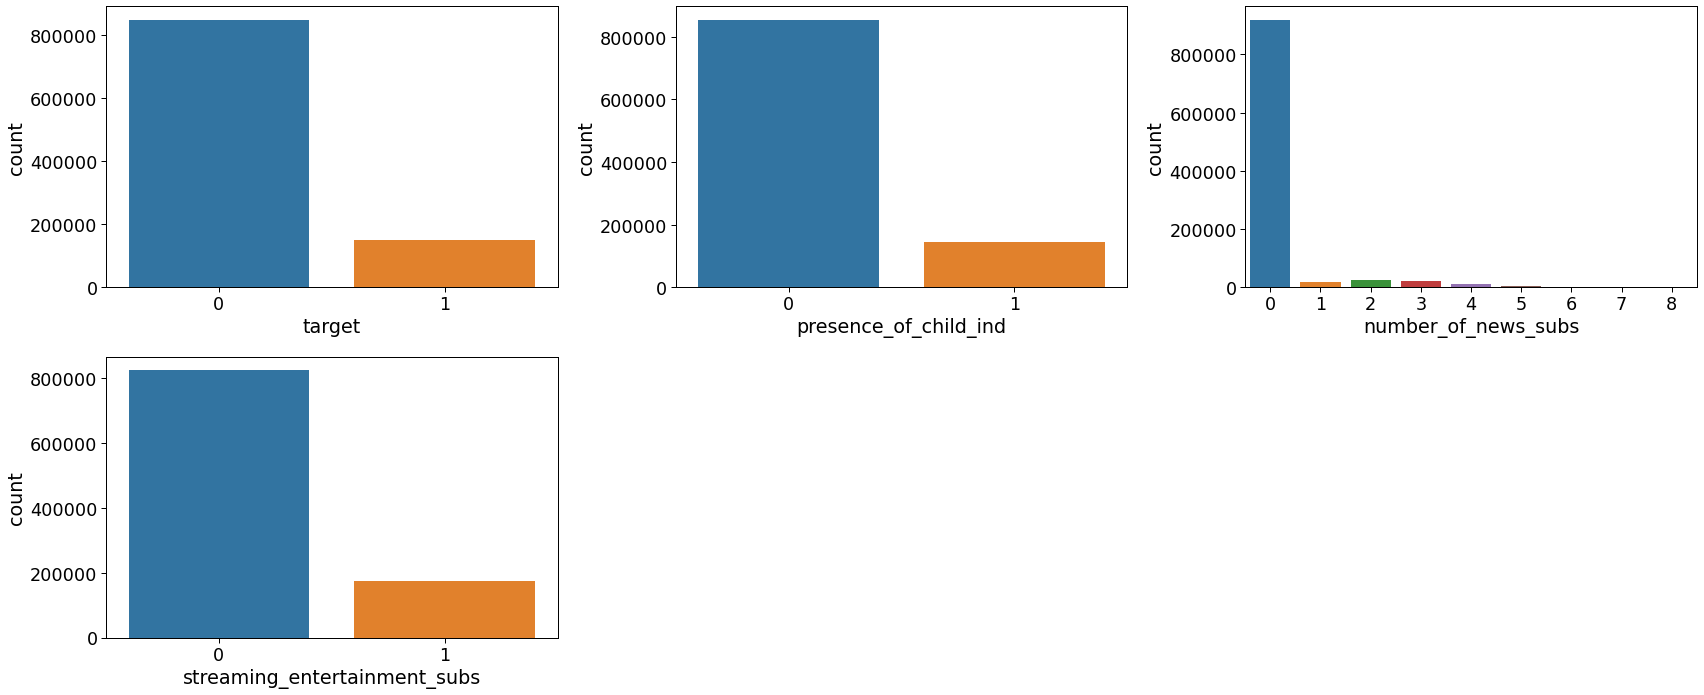

In [314]:
#Plotting Discrete Feature
sns.set_context('paper',font_scale=2 )
fig = plt.figure(figsize=(24,10))
for index,col in enumerate(disc):
    plt.subplot(2,3,index+1)
    sns.countplot(x=col ,data=df)
    #plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

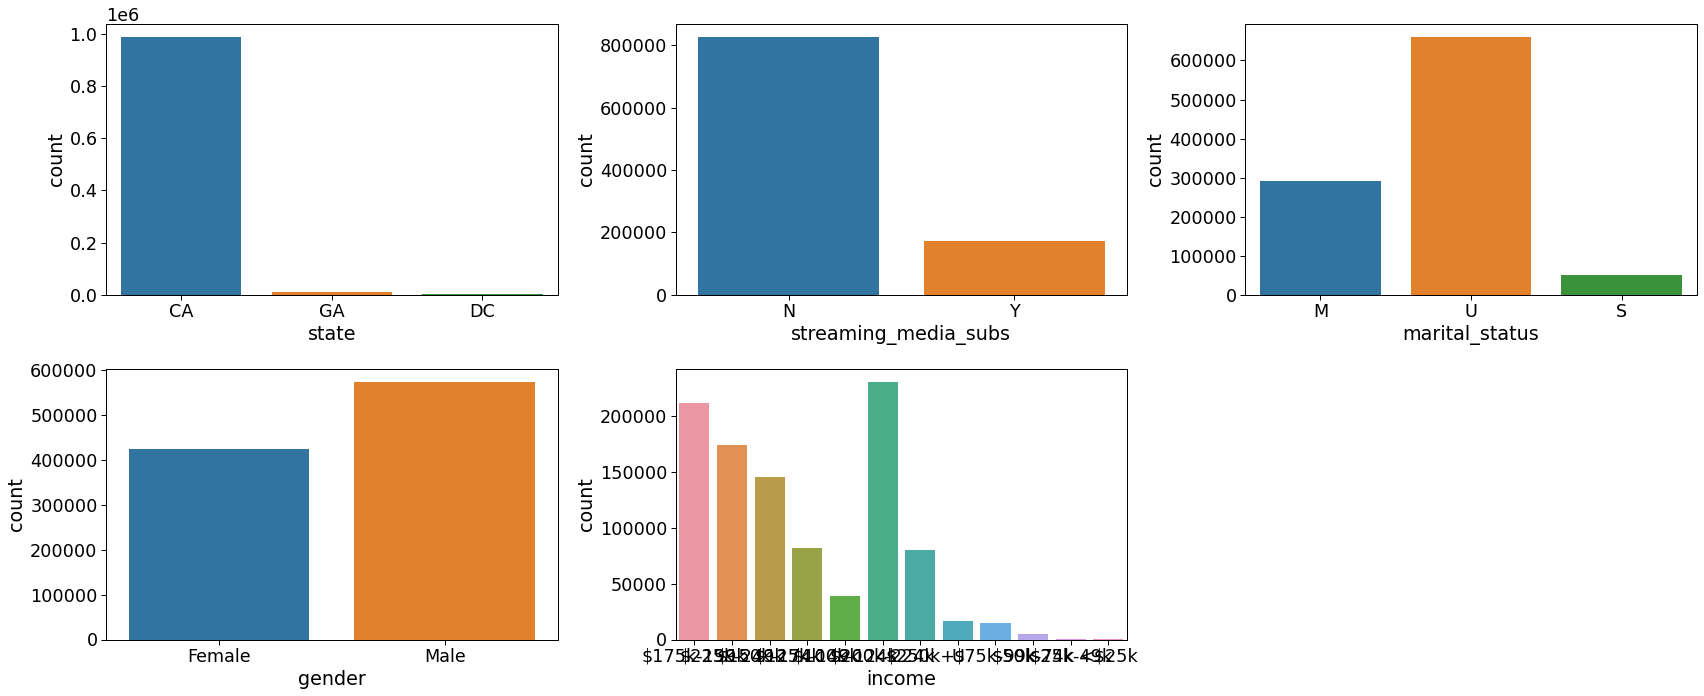

In [315]:
#Plotting Categorical Feature
sns.set_context('paper',font_scale=2 )
fig = plt.figure(figsize=(24,10))
for index,col in enumerate(cat_cols):
    plt.subplot(2,3,index+1)
    sns.countplot(x=col ,data=df)
    #plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

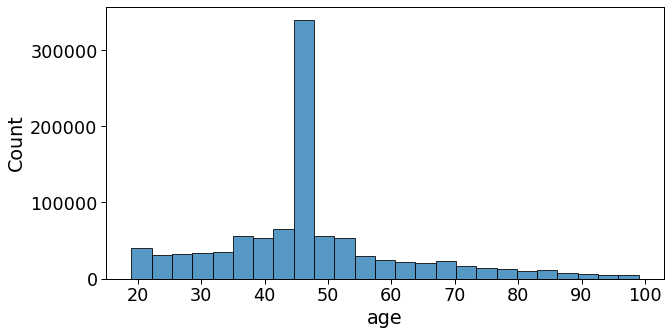

In [316]:
#Taking a look at the age distribution -- looks like there's alot of older and middle aged users. 45 year old spike.
plt.figure(figsize=(10,5))
sns.histplot(data=df, x= 'age', bins= 25)
plt.show()


# Model Building

In [317]:
#Dropping anon_person_id and putting it into a numpy array
users = df['anon_person_id'].values

#Dropping the user identifer for model 
df = df.drop('anon_person_id', axis=1)

In [318]:
#Creating dummie variables
df = pd.get_dummies(df, drop_first=True)

In [319]:
df.head()

,target,presence_of_child_ind,streaming_entertainment_subs,number_of_news_subs,age,state_DC,state_GA,streaming_media_subs_Y,marital_status_S,marital_status_U,gender_Male,income_$125k-149k,income_$150k-174k,income_$175k-199k,income_$200k-224k,income_$225k-249k,income_$250k+,income_$25k-49k,income_$50k-74k,income_$75k-99k,income_<$25k,income_U
0,0,0,0,0,43.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,90.0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,0,1,0,46.0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,25.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,62.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [325]:
## Creating a Logistic Regression Model ##

#Creating Target and Feature Variables for Logistic Regression

y = df['target'].values
X = df.drop('target', axis=1).values


# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=17)


#Pipeline steps
steps = [('scaler', StandardScaler()),
        ('LogisticRegression', LogisticRegression())]

#Pipeline
pipeline = Pipeline(steps)

#Fitting
pipeline.fit(X_train, y_train)

#Predict
y_pred = pipeline.predict(X_test)


# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[167996   2069]
 [  7872  22063]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    170065
           1       0.91      0.74      0.82     29935

    accuracy                           0.95    200000
   macro avg       0.93      0.86      0.89    200000
weighted avg       0.95      0.95      0.95    200000



In [321]:
#Getting Probababilties - Using all the data as if it was a new sample  
predictions = pipeline.predict(X)
y_pred_prob = pipeline.predict_proba(X)[:,1] 

In [322]:
#Final output
final = pd.DataFrame({'anon_person_id':users,
                       'target': df['target'],
                        'prediction': predictions,
                      'probability':y_pred_prob})

#Outputting
final.to_csv('scores.csv')

In [323]:
print(final)

        anon_person_id  target  prediction  probability
0                    1       0           0     0.210363
1                    2       0           0     0.000866
2                    3       1           1     0.961133
3                    4       0           0     0.026114
4                    5       0           0     0.044043
...                ...     ...         ...          ...
999995             496       0           0     0.203077
999996             497       0           0     0.020414
999997             498       1           1     0.999996
999998             499       0           0     0.009924
999999             500       0           1     0.651328

[1000000 rows x 4 columns]


In [326]:
#Cross Validation to ensure my model generalizes well to unseen data. 
#Using the training data, even though I've split my data into a training and test

cv_scores = cross_val_score(pipeline, X_train, y_train, scoring = 'recall', cv=5)

print(cv_scores)
print(np.mean(cv_scores))

[0.73928467 0.73168899 0.73925382 0.73687505 0.73416242]
0.7362529920179078


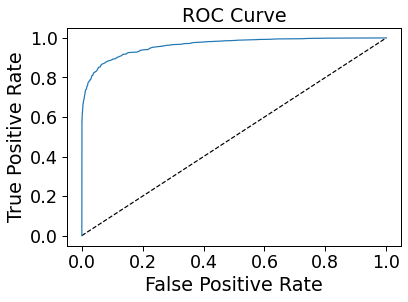

In [327]:
# Generate ROC curve values: fpr, tpr, thresholds

#For ROC curv
y_pred_prob2 = pipeline.predict_proba(X_test)[:,1] 

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob2)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [333]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob2)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.9629605789759071
AUC scores computed using 5-fold cross-validation: [0.9639115  0.96263469 0.96322303 0.96308049 0.96215866]
